### Task 1: Regularizing figures with straight lines

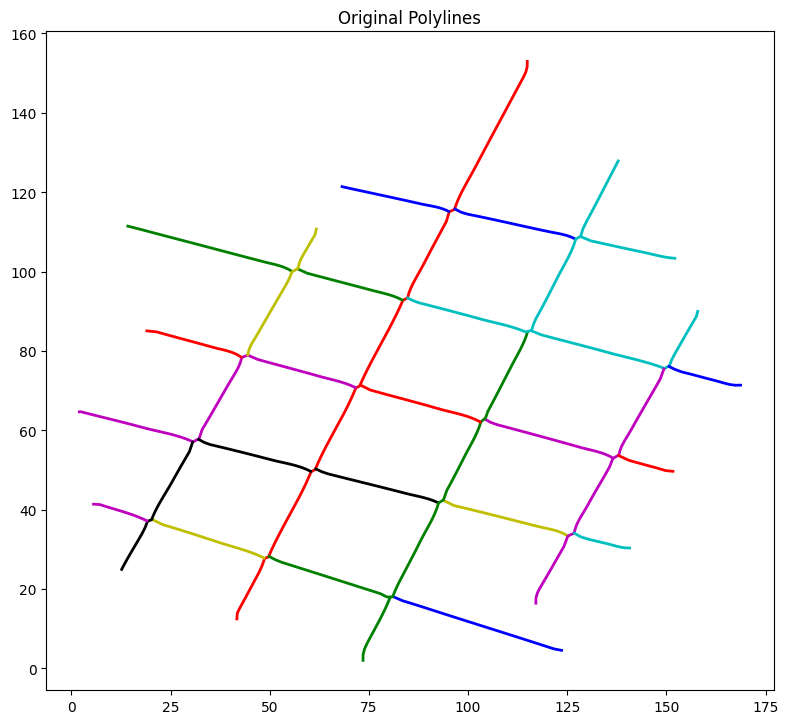

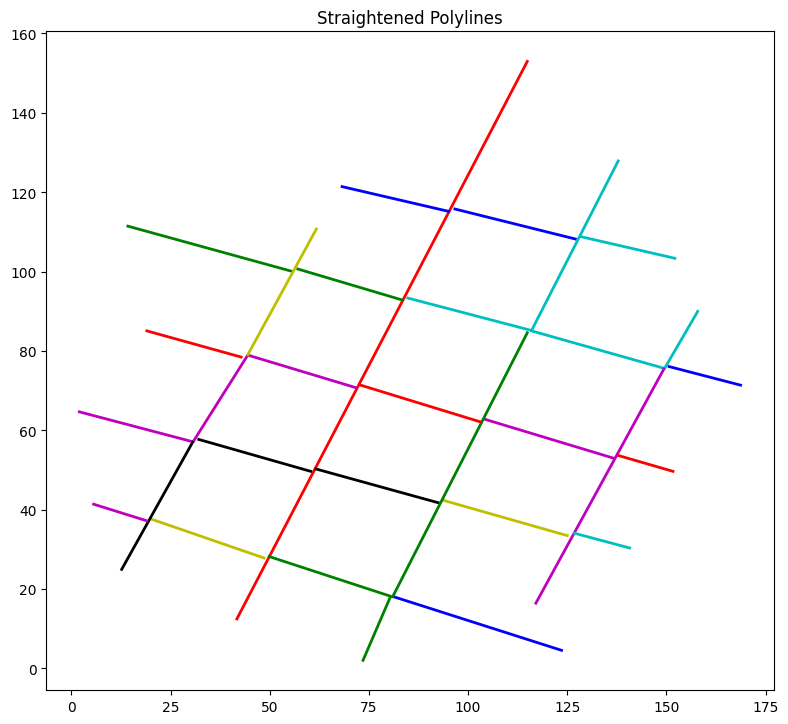

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][::, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot(paths_XYs, title="Polyline"):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            if len(XY) > 0:
                ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    ax.set_title(title)
    plt.show()

def rdp_simplify(polyline, epsilon):
    """
    Simplifies a polyline using the RDP algorithm.
    
    :param polyline: Array of shape (n_points, 2) where each row is a point (x, y)
    :param epsilon: Distance threshold to determine if a point is significant
    :return: Simplified polyline
    """
    def rdp(points, epsilon):
        def perpendicular_distance(point, line_start, line_end):
            if np.array_equal(line_start, line_end):
                return euclidean(point, line_start)
            line_len = euclidean(line_start, line_end)
            return (np.abs((line_end[1] - line_start[1]) * point[0] - (line_end[0] - line_start[0]) * point[1] + line_end[0] * line_start[1] - line_end[1] * line_start[0]) / line_len)
        
        if len(points) < 3:
            return points
        
        start, end = points[0], points[-1]
        dist = [perpendicular_distance(point, start, end) for point in points]
        index = np.argmax(dist)
        if dist[index] > epsilon:
            first_half = rdp(points[:index + 1], epsilon)
            second_half = rdp(points[index:], epsilon)
            return np.vstack((first_half[:-1], second_half))
        else:
            return np.array([start, end])
    
    return rdp(polyline, epsilon)

def straighten_polylines(polylines, epsilon):
    straightened_polylines = []
    for polyline in polylines:
        straightened_path = []
        for segment in polyline:
            if len(segment) > 1:
                segment = segment[segment[:, 0].argsort()] 
                simplified_segment = rdp_simplify(segment, epsilon)
                straightened_path.append(simplified_segment)
            else:
                straightened_path.append(segment) 
        straightened_polylines.append(straightened_path)
    return straightened_polylines

def write_csv(polylines, csv_path):
    with open(csv_path, 'w') as f:
        for i, path in enumerate(polylines):
            for polyline in path:
                for point in polyline:
                    f.write(f"{i},{point[0]},{point[1]}\n")

csv_path = '../data/frag2.csv'
output_csv_path = 'straightened_polylines.csv'

polylines = read_csv(csv_path)
plot(polylines, title="Original Polylines")

epsilon = 2.0  # Adjustable Value
straightened_polylines = straighten_polylines(polylines, epsilon)

plot(straightened_polylines, title="Straightened Polylines")
write_csv(straightened_polylines, output_csv_path)


### Regularizing shapes

Processing CSV file at ../data/isolated.csv.


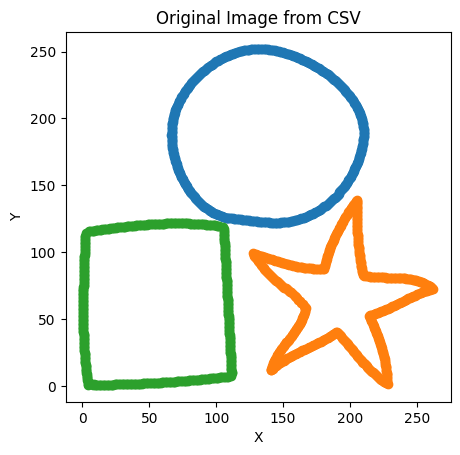

Processing the image at ../data/isolated.svg.


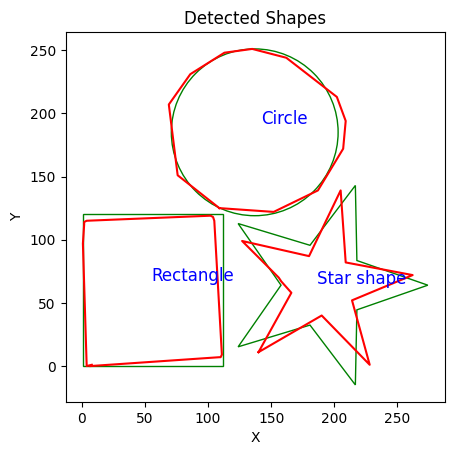

In [8]:
import numpy as np
import cv2
import os
import svgpathtools
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Circle

def read_csv(csv_path):
    try:
        np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
        if np_path_XYs.size == 0:
            raise ValueError("CSV file is empty or not properly formatted")
        
        path_XYs = []
        for i in np.unique(np_path_XYs[:, 0]):
            npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
            if npXYs.size == 0:
                continue
            XYs = []
            for j in np.unique(npXYs[:, 0]):
                XY = npXYs[npXYs[:, 0] == j][:, 1:]
                if XY.size == 0:
                    continue
                XYs.append(XY)
            path_XYs.append(XYs)
        
        return path_XYs
    
    except Exception as e:
        print(f"An error occurred: {e}")

def plot_csv_data(csv_path):
    path_XYs = read_csv(csv_path)
    
    if path_XYs:
        fig, ax = plt.subplots()
        for XYs in path_XYs:
            for XY in XYs:
                ax.plot(XY[:, 0], XY[:, 1], 'o-', label='Original Shape')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title('Original Image from CSV')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()

def classify_shape(contour):
    epsilon = 0.04 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    num_vertices = len(approx)

    if num_vertices == 2:
        return "Straight line"
    elif num_vertices == 3:
        return "Triangle"
    elif num_vertices == 4:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h
        if 0.95 < aspect_ratio < 1.05:
            return "Square"
        else:
            return "Rectangle"
    elif num_vertices == 5:
        return "Regular Pentagon"
    elif num_vertices > 6:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        circularity = 4 * np.pi * (area / (perimeter * perimeter))
        if circularity > 0.8:
            return "Circle"
        elif num_vertices == 10:
            return "Star shape"
        else:
            return "Regular Polygon"

    return "Unknown Shape"

def draw_regular_shape(ax, shape, contour):
    if shape == "Circle":
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = contour[0][0]
        radius = int(np.sqrt(cv2.contourArea(contour) / np.pi))
        circle = Circle((cX, cY), radius, fill=False, edgecolor='green')
        ax.add_patch(circle)
    elif shape == "Square":
        x, y, w, h = cv2.boundingRect(contour)
        side = min(w, h)
        square = Polygon([[x, y], [x + side, y], [x + side, y + side], [x, y + side]], closed=True, fill=False, edgecolor='green')
        ax.add_patch(square)
    elif shape == "Rectangle":
        x, y, w, h = cv2.boundingRect(contour)
        rectangle = Polygon([[x, y], [x + w, y], [x + w, y + h], [x, y + h]], closed=True, fill=False, edgecolor='green')
        ax.add_patch(rectangle)
    elif shape == "Triangle":
        x, y, w, h = cv2.boundingRect(contour)
        triangle = Polygon([[x, y], [x + w / 2, y + h], [x + w, y]], closed=True, fill=False, edgecolor='green')
        ax.add_patch(triangle)
    elif shape == "Star shape":
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = contour[0][0]
        radius_outer = int(np.sqrt(cv2.contourArea(contour*2) / np.pi))
        radius_inner = radius_outer / 2.5
        angles = np.linspace(0, 2 * np.pi, 11)
        points = []
        for i, angle in enumerate(angles):
            if i % 2 == 0:
                points.append([cX + np.cos(angle) * radius_outer, cY + np.sin(angle) * radius_outer])
            else:
                points.append([cX + np.cos(angle) * radius_inner, cY + np.sin(angle) * radius_inner])
        points = np.array(points)
        star = Polygon(points, closed=True, fill=False, edgecolor='green')
        ax.add_patch(star)
    elif shape == "Regular Polygon":
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = contour[0][0]
        num_vertices = len(contour)
        radius = int(np.sqrt(cv2.contourArea(contour) / np.pi))
        angles = np.linspace(0, 2 * np.pi, num_vertices + 1)
        points = np.array([[cX + np.cos(angle) * radius, cY + np.sin(angle) * radius] for angle in angles])
        polygon = Polygon(points, closed=True, fill=False, edgecolor='green')
        ax.add_patch(polygon)

def detect_shapes(image_path):
    try:
        paths, _ = svgpathtools.svg2paths(image_path)
        fig, ax = plt.subplots()

        for path in paths:
            points = []
            for segment in path:
                points.append([segment.start.real, segment.start.imag])
                points.append([segment.end.real, segment.end.imag])
            points = np.array(points, dtype=np.float32)

            if len(points) > 0:
                contour = np.array(points, dtype=np.int32)
                shape = classify_shape(contour)
                plt.plot(contour[:, 0], contour[:, 1], 'r-')
                plt.text(np.mean(contour[:, 0]), np.mean(contour[:, 1]), shape, fontsize=12, color='blue')
                draw_regular_shape(ax, shape, contour)

        plt.gca().set_aspect('equal', adjustable='box')
        plt.title('Detected Shapes')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()

    except Exception as e:
        print(f"An error occurred while detecting shapes: {e}")

def main():
    csv_path = '../data/isolated.csv'
    image_path = '../data/isolated.svg'
    
    if os.path.exists(csv_path):
        print(f"Processing CSV file at {csv_path}.")
        plot_csv_data(csv_path)
    else:
        print(f"The CSV file does not exist at {csv_path}.")
    
    if os.path.exists(image_path):
        print(f"Processing the image at {image_path}.")
        detect_shapes(image_path)
    else:
        print(f"The image does not exist at {image_path}.")
    
if __name__ == "__main__":
    main()


the shapes with thin lines are the regularised outputs

### Converting image to a polyline csv dataset

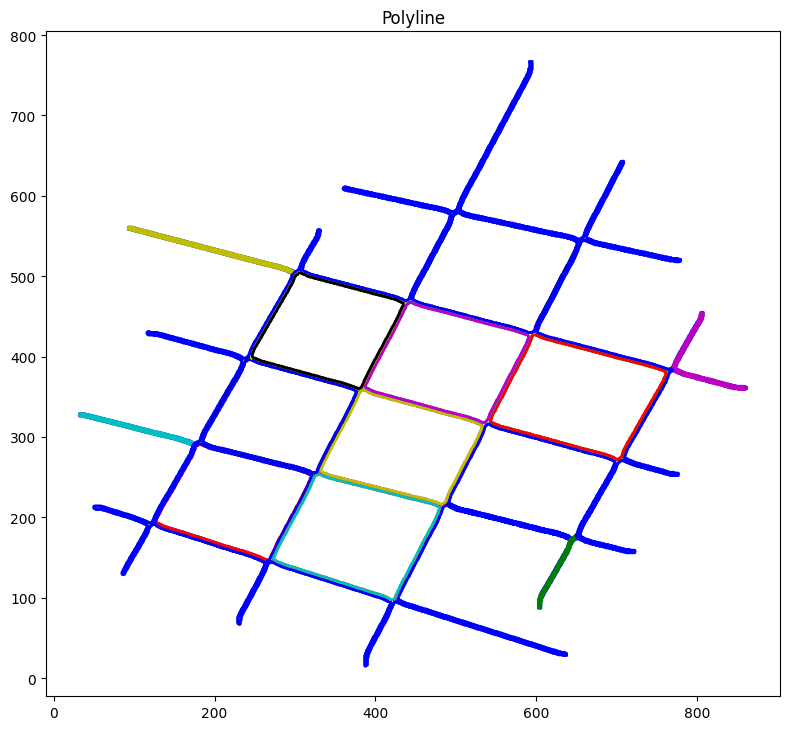

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = '../data/img.png'
image = cv2.imread(image_path)
image_height = image.shape[0]

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(gray, 50, 150, apertureSize=3)

contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def save_contours_to_csv(contours, csv_path, image_height):
    with open(csv_path, 'w') as f:
        for i, contour in enumerate(contours):
            for point in contour:
                x, y = point[0]
                y = image_height - y  
                f.write(f"{i},{0},{x},{y}\n")

csv_path = '../data/contours.csv'
save_contours_to_csv(contours, csv_path, image_height)

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 2:]
        path_XYs.append(npXYs)
    return path_XYs

def plot(paths_XYs, title="Polyline"):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        if len(XYs) > 0:
            ax.plot(XYs[:, 0], XYs[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    ax.set_title(title)
    plt.show()

paths_XYs = read_csv(csv_path)
plot(paths_XYs)

### Finding lines of Symmetry of a Regular Shape

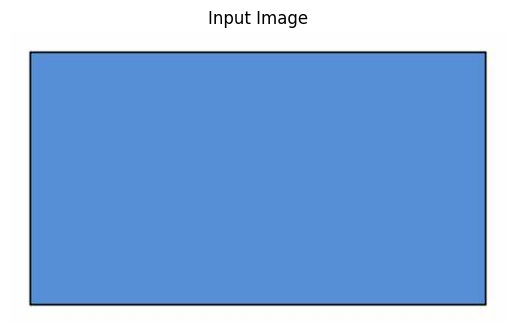

The shape is vertically symmetric.
The shape is horizontally symmetric.
The shape is not symmetric along the major diagonal.
The shape is not symmetric along the minor diagonal.


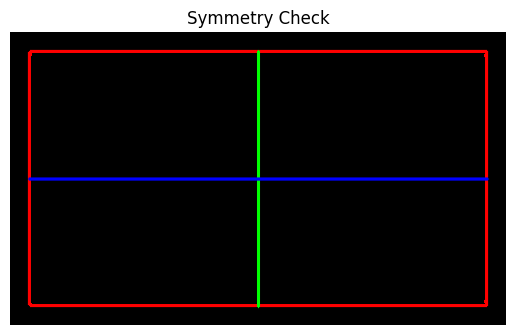

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = '../data/rectangle.jpg'
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

_, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)

contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contour_image = np.zeros_like(image) 
cv2.drawContours(contour_image, contours, -1, (0, 0, 255), 2)  

def check_symmetry(half1, half2):
    """Check if two halves are symmetric."""
    if half1.shape != half2.shape:
        min_height = min(half1.shape[0], half2.shape[0])
        min_width = min(half1.shape[1], half2.shape[1])
        half1 = half1[:min_height, :min_width]
        half2 = half2[:min_height, :min_width]
    difference = cv2.absdiff(half1, half2)
    symmetry_score = np.sum(difference)
    return symmetry_score

def detect_symmetry(contour):
    x, y, w, h = cv2.boundingRect(contour)
    roi = binary[y:y+h, x:x+w]

    if w % 2 != 0:
        w -= 1
        roi = binary[y:y+h, x:x+w-1]
    if h % 2 != 0:
        h -= 1
        roi = binary[y:y+h-1, x:x+w]

    left_half = roi[:, :w//2]
    right_half = roi[:, w//2:]
    right_half_flipped = cv2.flip(right_half, 1)

    top_half = roi[:h//2, :]
    bottom_half = roi[h//2:, :]
    bottom_half_flipped = cv2.flip(bottom_half, 0)

    if check_symmetry(left_half, right_half_flipped) < 1e5:
        print("The shape is vertically symmetric.")
        cv2.line(contour_image, (x + w // 2, y), (x + w // 2, y + h), (0, 255, 0), 2)
    else:
        print("The shape is not vertically symmetric.")

    if check_symmetry(top_half, bottom_half_flipped) < 1e5:
        print("The shape is horizontally symmetric.")
        cv2.line(contour_image, (x, y + h // 2), (x + w, y + h // 2), (255, 0, 0), 2)
    else:
        print("The shape is not horizontally symmetric.")

    diag1 = cv2.transpose(roi)
    diag1_flipped = cv2.flip(diag1, 1)
    if check_symmetry(roi, diag1_flipped) < 1e5:
        print("The shape is symmetric along the major diagonal.")
        cv2.line(contour_image, (x, y), (x + w, y + h), (0, 255, 255), 2)
    else:
        print("The shape is not symmetric along the major diagonal.")

    diag2 = cv2.flip(cv2.transpose(cv2.flip(roi, 0)), 0)
    if check_symmetry(roi, diag2) < 1e5:
        print("The shape is symmetric along the minor diagonal.")
        cv2.line(contour_image, (x + w, y), (x, y + h), (255, 0, 255), 2)
    else:
        print("The shape is not symmetric along the minor diagonal.")

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Input Image')
plt.axis('off')  
plt.show()

for contour in contours:
    detect_symmetry(contour)

plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.title('Symmetry Check')
plt.axis('off') 


### Curve Completion

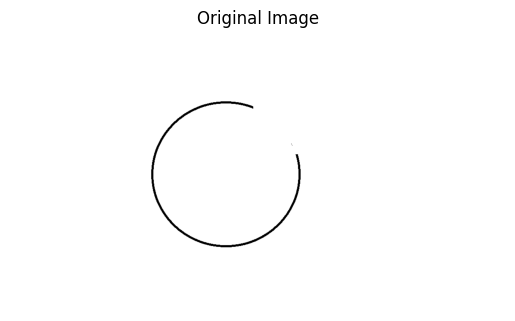

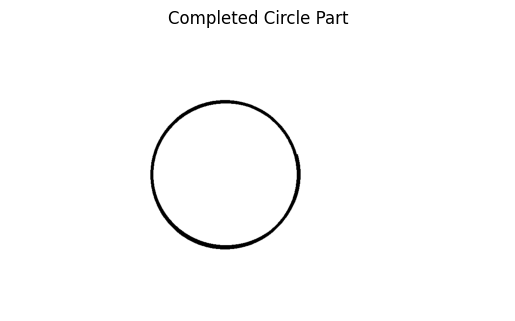

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt  

def find_missing_arc(center, radius, edges):
    mask = np.zeros(edges.shape, dtype=np.uint8)
    cv2.circle(mask, center, radius, 255, 1)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return 0, 360

    contour = max(contours, key=cv2.contourArea)
    contour = np.squeeze(contour)

    angles = np.arctan2(contour[:, 1] - center[1], contour[:, 0] - center[0])
    angles = np.degrees(angles)
    angles = np.mod(angles + 360, 360) 

    start_angle = np.min(angles)
    end_angle = np.max(angles)

    if end_angle - start_angle > 180:
        start_angle, end_angle = end_angle, start_angle 
    return start_angle, end_angle

def complete_missing_circle_part(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100,
                               param1=50, param2=30, minRadius=20, maxRadius=200)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title('Original Image')
    plt.axis('off') 
    plt.show()

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            center = (i[0], i[1])
            radius = i[2]

            start_angle, end_angle = find_missing_arc(center, radius, edges)

            thickness = 5 
            cv2.ellipse(img, center, (radius, radius), 0, start_angle, end_angle, (0, 0, 0), thickness)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.title('Completed Circle Part')
    plt.axis('off') 
    plt.show()

complete_missing_circle_part('../data/circle.png')


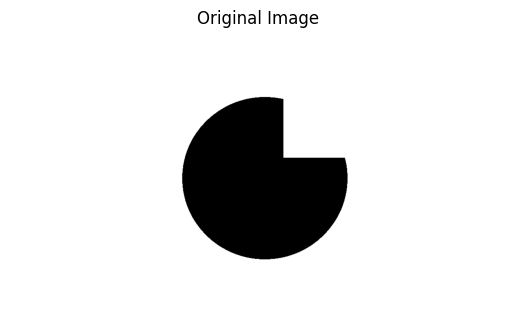

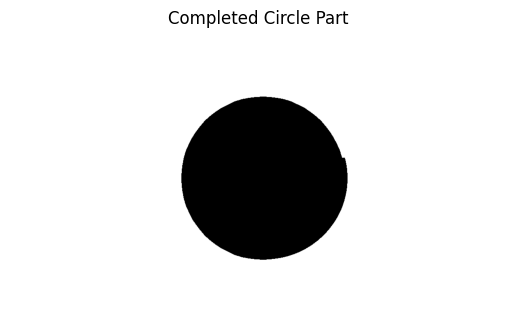

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt  

def find_missing_arc(center, radius, edges):
    mask = np.zeros(edges.shape, dtype=np.uint8)
    cv2.circle(mask, center, radius, 255, 1)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return 0, 360

    contour = max(contours, key=cv2.contourArea)
    contour = np.squeeze(contour)

    angles = np.arctan2(contour[:, 1] - center[1], contour[:, 0] - center[0])
    angles = np.degrees(angles)
    angles = np.mod(angles + 360, 360)  

    start_angle = np.min(angles)
    end_angle = np.max(angles)

    if end_angle - start_angle > 180:
        start_angle, end_angle = end_angle, start_angle 

    return start_angle, end_angle

def complete_missing_circle_part(image_path):
    img = cv2.imread(image_path)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title('Original Image')
    plt.axis('off')  
    plt.show()

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100,
                               param1=50, param2=30, minRadius=20, maxRadius=200)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            center = (i[0], i[1])
            radius = i[2]

            start_angle, end_angle = find_missing_arc(center, radius, edges)

            color_sample = img[center[1], center[0]]
            color = tuple(map(int, color_sample))

            mask = np.zeros_like(img)
            cv2.ellipse(mask, center, (radius, radius), 0, start_angle, end_angle, (255, 255, 255), thickness=-1)

            img[mask[:,:,0] > 0] = color

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.title('Completed Circle Part')
    plt.axis('off')  
    plt.show()

complete_missing_circle_part('../data/circle_fill.png')


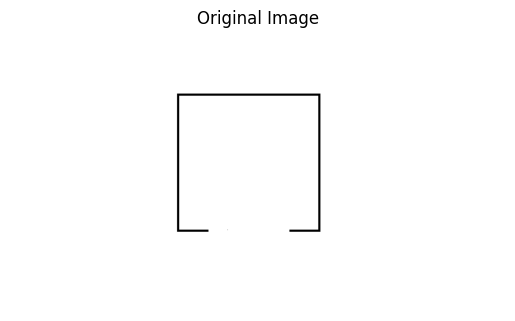

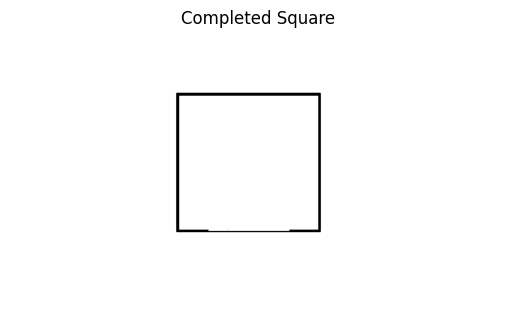

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 

def complete_square(image_path):
    img = cv2.imread(image_path)

    img_rgb_original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb_original)
    plt.title('Original Image')
    plt.axis('off')  
    plt.show()

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
 
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=50, maxLineGap=10)
    
    if lines is not None:
        endpoints = []
        for line in lines:
            x1, y1, x2, y2 = line[0]
            endpoints.extend([(x1, y1), (x2, y2)])
        x_coords, y_coords = zip(*endpoints)
        left, top = min(x_coords), min(y_coords)
        right, bottom = max(x_coords), max(y_coords)
        
        black_color = (0, 0, 0) 
        cv2.line(img, (left, top), (right, top), black_color, 2) 
        cv2.line(img, (left, bottom), (right, bottom), black_color, 2)  
        cv2.line(img, (left, top), (left, bottom), black_color, 2)  
        cv2.line(img, (right, top), (right, bottom), black_color, 2)  
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img_rgb)
    plt.title('Completed Square')
    plt.axis('off')  
    plt.show()

complete_square('../data/square.png')
